# A New Feature - College

## Author: Brady Monks

### Date: 4/23

Due to the sheer magnitude of categorical data, I wanted to implement my own unique analysis. In order to do this, I needed to construct a little model with the intent of giving an athlete odds of becoming a professional based on two things, where they grew up, and what college they attended. 

In [21]:
import pandas as pd

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv("AthleteDatabase.csv")

# Create a new DataFrame grouped by league and college
grouped = df.groupby(['League', 'College']).size().reset_index(name='Count')

# Create a new column for the total count of each league
total_count = grouped.groupby('League')['Count'].transform('sum')
grouped['LeagueTotal'] = total_count

# Create a new column for the percentage of each college in each league
grouped['Percentage'] = grouped['Count'] / grouped['LeagueTotal'] * 100

# Sort the DataFrame by league and percentage in descending order
college_df = grouped.sort_values(['League', 'Percentage'], ascending=[True, False])

# Add a new column for the ranks of each college in each league
college_df['Rank'] = college_df.groupby('League')['Percentage'].rank(method='dense', ascending=False)

# Sort the DataFrame by rank and then league
college_df = college_df.sort_values(['Rank', 'League'])

# Save DF to CSV
college_df.to_csv('ranks_percents.csv', index=False)

# Print the final DataFrame
college_df.head(10)


C:\Users\brady\AppData\Local\Temp\ipykernel_35868\2008137310.py:4: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.


,League,College,Count,LeagueTotal,Percentage,Rank
925,MLB,University of Texas,107,7540,1.419098,1.0
1387,NBA,University of Kentucky,109,4371,2.493709,1.0
2180,NFL,University of Notre Dame,523,24459,2.138272,1.0
917,MLB,University of Southern California,105,7540,1.392573,2.0
1363,NBA,University of California-Los Angeles,94,4371,2.150538,2.0
2196,NFL,University of Southern California,465,24459,1.901141,2.0
16,MLB,Arizona State University,101,7540,1.339523,3.0
1411,NBA,University of North Carolina at Chapel Hill,93,4371,2.127660,3.0
1934,NFL,Ohio State University,422,24459,1.725336,3.0
757,MLB,Stanford University,86,7540,1.140584,4.0


In [16]:
# Filter the college_df DataFrame to include only colleges with rank 10 or lower
filtered_colleges = college_df.loc[college_df['Rank'] <= 10, 'College']

# Get the unique values from the filtered colleges
unique_colleges = filtered_colleges.unique()

# Filter the college_df DataFrame to include only rows with colleges from the unique_colleges list
top_10 = college_df[college_df['College'].isin(unique_colleges)]

# Save DF to CSV
top_10.to_csv('top10.csv', index=False)

# Print the resulting DataFrame
top_10.head(10)



,League,College,Count,LeagueTotal,Percentage,Rank
925,MLB,University of Texas,107,7540,1.419098,1.0
1387,NBA,University of Kentucky,109,4371,2.493709,1.0
2180,NFL,University of Notre Dame,523,24459,2.138272,1.0
917,MLB,University of Southern California,105,7540,1.392573,2.0
1363,NBA,University of California-Los Angeles,94,4371,2.150538,2.0
2196,NFL,University of Southern California,465,24459,1.901141,2.0
16,MLB,Arizona State University,101,7540,1.339523,3.0
1411,NBA,University of North Carolina at Chapel Hill,93,4371,2.127660,3.0
1934,NFL,Ohio State University,422,24459,1.725336,3.0
757,MLB,Stanford University,86,7540,1.140584,4.0


### Top 10 Schools

From these ranks, I wanted to visualize the top 10 schools for each league.

Each school in the following graph is top 10 in at least one league, I created the graph to see how they fare in other leagues. 

I used ggplot as I am familiar with it and it's facet_wrap abilities. 

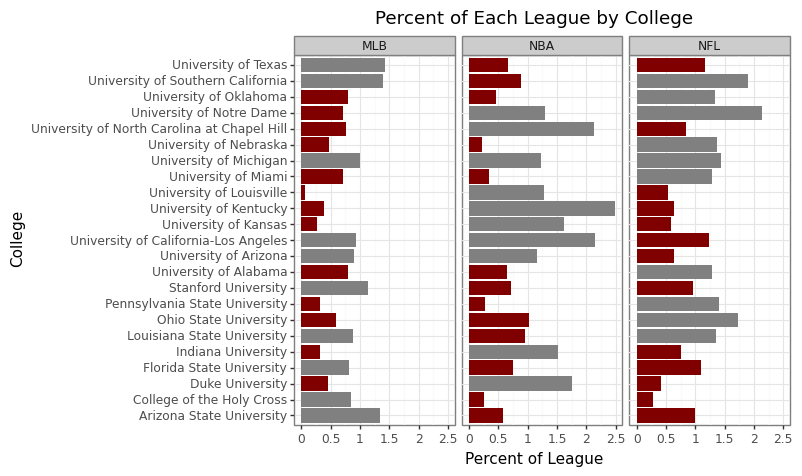

<ggplot: (129616101357)>

In [3]:
from plotnine import ggplot, aes, geom_col, facet_wrap, labs, coord_flip, theme_bw, theme, scale_fill_manual

# Plot the data using ggplot
(ggplot(top_10, aes(x='College', y='Percentage', fill='Rank <= 10')) +
 geom_col() +
 facet_wrap('~League') +
 coord_flip() +
 scale_fill_manual(values=['maroon', 'gray']) +
 labs(x='College', y='Percent of League', title='Percent of Each League by College') +
 theme_bw() +
 theme(legend_position='none'))


### Final Ranking System - College

In [15]:
import pandas as pd
import numpy as np

# Load the CSV file into a DataFrame
df = pd.read_csv('AthleteDatabase.csv')

# Remove rows with NaN values in the 'College' column
df = df.dropna(subset=['College'])

# Group the data by league and College, and calculate the percentage for each College in each league
grouped = df.groupby(['League', 'College']).size().reset_index(name='Count')
grouped['Total'] = grouped.groupby('League')['Count'].transform('sum')
grouped['Percent'] = grouped['Count'] / grouped['Total']

# Calculate the rank for each College within each league
grouped['Rank'] = grouped.groupby('League')['Percent'].rank(method='min', ascending=False)

# Pivot the data to show each College's rank in each league
College_pivot_df = pd.pivot_table(grouped, values='Rank', index='College', columns='League')

# Add a column for total rank
College_pivot_df['Total'] = College_pivot_df.sum(axis=1)

# Add a column for NaN count
College_pivot_df['NAN'] = College_pivot_df.isnull().sum(axis=1)

# Fill NaN values with the average rank
total_nans = College_pivot_df['NAN'].sum()
total_colleges = College_pivot_df.shape[0]
average_rank = College_pivot_df['Total'].sum() / (3 * total_colleges - total_nans)
College_pivot_df = College_pivot_df.fillna(average_rank)

# Drop Re-enter totals
College_pivot_df = College_pivot_df.drop(columns = ['Total','NAN'])
College_pivot_df['Total'] = College_pivot_df.sum(axis=1)

# Add a new column with rankings based on the Total column
College_pivot_df = College_pivot_df.sort_values(by='Total')
College_pivot_df['Rank'] = College_pivot_df['Total'].rank(method='min')

# Read in the conference data from the original DataFrame
conference_df = df[['College', 'conference_College']].drop_duplicates()

# Join the conference data to the college_df DataFrame
Final_college = pd.merge(College_pivot_df, conference_df, on='College')

# Round all the values in the table to two decimal places
Final_college = Final_college.round(0)

# Save DataFrame to CSV
Final_college.to_csv("FinalCollegeRankings.csv", index=True)

# Print the final DataFrame
Final_college.head(10)


C:\Users\brady\AppData\Local\Temp\ipykernel_35868\1125432196.py:5: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.


,College,MLB,NBA,NFL,Total,Rank,conference_College
0,University of Michigan,5.0,9.0,4.0,18.0,1.0,Big Ten
1,University of California-Los Angeles,6.0,2.0,12.0,20.0,2.0,Pac-12
2,University of Notre Dame,17.0,7.0,1.0,25.0,3.0,Independent
3,University of Southern California,2.0,22.0,2.0,26.0,4.0,Pac-12
4,Louisiana State University,8.0,19.0,7.0,34.0,5.0,SEC
5,Ohio State University,28.0,16.0,3.0,47.0,6.0,Big Ten
6,University of North Carolina at Chapel Hill,13.0,3.0,35.0,51.0,7.0,ACC
7,University of Illinois,15.0,19.0,24.0,58.0,8.0,Big Ten
8,University of Texas,1.0,41.0,17.0,59.0,9.0,Big 12
9,Florida State University,10.0,33.0,21.0,64.0,10.0,ACC


### A New Feature - BirthPlace

In [17]:
import pandas as pd

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv("AthleteDatabase.csv")

# Create a new DataFrame grouped by league and BirthPlace
grouped = df.groupby(['League', 'BirthPlace']).size().reset_index(name='Count')

# Create a new column for the total count of each league
total_count = grouped.groupby('League')['Count'].transform('sum')
grouped['LeagueTotal'] = total_count

# Create a new column for the percentage of each BirthPlace in each league
grouped['Percentage'] = grouped['Count'] / grouped['LeagueTotal'] * 100

# Filter the DataFrame to include only NFL, MLB, and NBA leagues
filtered = grouped[grouped['League'].isin(['NFL', 'MLB', 'NBA'])]

# Sort the DataFrame by league and percentage in descending order
BirthPlace_df = filtered.sort_values(['League', 'Percentage'], ascending=[True, False])

# Add a new column for the ranks of each BirthPlace in each league
BirthPlace_df['Rank'] = BirthPlace_df.groupby('League')['Percentage'].rank(method='dense', ascending=False)

# Sort the DataFrame by rank and then league
BirthPlace_df = BirthPlace_df.sort_values(['Rank', 'League'])

# Save DF to CSV
BirthPlace_df.to_csv('ranks_percents.csv', index=False)

# Print the final DataFrame
BirthPlace_df.head(10)



C:\Users\brady\AppData\Local\Temp\ipykernel_35868\1908601108.py:4: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.


,League,BirthPlace,Count,LeagueTotal,Percentage,Rank
1336,MLB,"Los Angeles, CA",152,7541,2.015648,1.0
2838,NBA,"Chicago, IL",137,4177,3.279866,1.0
5127,NFL,"Chicago, IL",474,24104,1.966479,1.0
427,MLB,"Chicago, IL",107,7541,1.418910,2.0
3693,NBA,"Philadelphia, PA",112,4177,2.681350,2.0
7281,NFL,"Los Angeles, CA",449,24104,1.862761,2.0
1066,MLB,"Houston, TX",88,7541,1.166954,3.0
3402,NBA,"Los Angeles, CA",111,4177,2.657410,3.0
6655,NFL,"Houston, TX",310,24104,1.286094,3.0
1639,MLB,"New York, NY",69,7541,0.914998,4.0


In [19]:
# Filter the college_df DataFrame to include only BirthPlaces with rank 10 or lower
filtered_BirthPlace = BirthPlace_df.loc[BirthPlace_df['Rank'] <= 10, 'BirthPlace']

# Get the unique values from the filtered BirthPlaces
unique_BirthPlace = filtered_BirthPlace.unique()

# Filter the BirthPlace_df DataFrame to include only rows with BirthPlaces from the unique_BirthPlaces list
top_10_BP = BirthPlace_df[BirthPlace_df['BirthPlace'].isin(unique_BirthPlace)]

# Save DF to CSV
top_10_BP.to_csv('top10_BP.csv', index=False)

# Print the resulting DataFrame
print(top_10_BP)



     League         BirthPlace  Count  LeagueTotal  Percentage  Rank
1336    MLB    Los Angeles, CA    152         7541    2.015648   1.0
2838    NBA        Chicago, IL    137         4177    3.279866   1.0
5127    NFL        Chicago, IL    474        24104    1.966479   1.0
427     MLB        Chicago, IL    107         7541    1.418910   2.0
3693    NBA   Philadelphia, PA    112         4177    2.681350   2.0
7281    NFL    Los Angeles, CA    449        24104    1.862761   2.0
1066    MLB        Houston, TX     88         7541    1.166954   3.0
3402    NBA    Los Angeles, CA    111         4177    2.657410   3.0
6655    NFL        Houston, TX    310        24104    1.286094   3.0
1639    MLB       New York, NY     69         7541    0.914998   4.0
3579    NBA       New York, NY     90         4177    2.154656   4.0
7625    NFL          Miami, FL    278        24104    1.153336   4.0
2040    MLB      San Diego, CA     66         7541    0.875215   5.0
2754    NBA       Brooklyn, NY    

### Top 10 BirthPlaces

From these ranks, I wanted to visualize the top 10 BirthPlaces for each league.

Each BirthPlace in the following graph is top 10 in at least one league, I created the graph to see how they fare in other leagues. 

I used ggplot as I am familiar with it and it's facet_wrap abilities. 

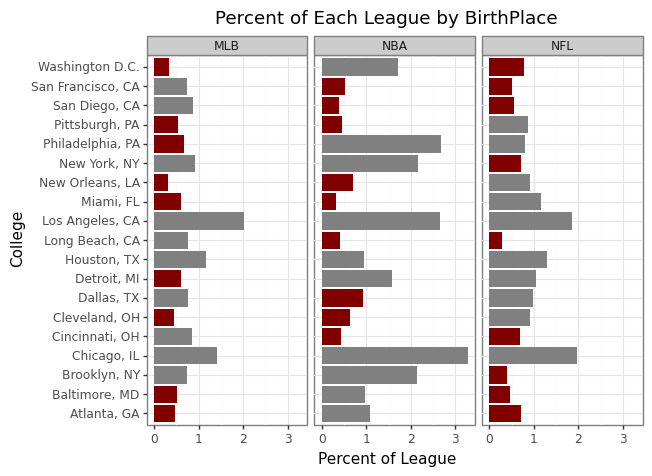

<ggplot: (129621257741)>

In [8]:
from plotnine import ggplot, aes, geom_col, facet_wrap, labs, coord_flip, theme_bw, theme, scale_fill_manual

# Plot the data using ggplot
(ggplot(top_10_BP, aes(x='BirthPlace', y='Percentage', fill='Rank <= 10')) +
 geom_col() +
 facet_wrap('~League') +
 coord_flip() +
 scale_fill_manual(values=['maroon', 'gray']) +
 labs(x='College', y='Percent of League', title='Percent of Each League by BirthPlace') +
 theme_bw() +
 theme(legend_position='none'))


### Final Ranking System - BirthPlace

In [20]:
import pandas as pd
import numpy as np

# Load the CSV file into a DataFrame
df = pd.read_csv('AthleteDatabase.csv')

# Remove rows with NaN values in the 'BirthPlace' column
df = df.dropna(subset=['BirthPlace'])

# Filter the data to include only rows with a ',' in the 'BirthPlace' column
df = df[df['BirthPlace'].str.contains(",")]

# Group the data by league and BirthPlace, and calculate the percentage for each BirthPlace in each league
grouped = df.groupby(['League', 'BirthPlace']).size().reset_index(name='Count')
grouped['Total'] = grouped.groupby('League')['Count'].transform('sum')
grouped['Percent'] = grouped['Count'] / grouped['Total']

# Calculate the rank for each BirthPlace within each league
grouped['Rank'] = grouped.groupby('League')['Percent'].rank(method='min', ascending=False)

# Pivot the data to show each BirthPlace's rank in each league
BirthPlace_divot_df = pd.pivot_table(grouped, values='Rank', index='BirthPlace', columns='League')

# Add a column for total rank
BirthPlace_divot_df['Total'] = BirthPlace_divot_df.sum(axis=1)

# Add a column for NaN count
BirthPlace_divot_df['NAN'] = BirthPlace_divot_df.isnull().sum(axis=1)

# Fill NaN values with the average rank
total_nans = BirthPlace_divot_df['NAN'].sum()
total_birthplaces = BirthPlace_divot_df.shape[0]
average_rank = BirthPlace_divot_df['Total'].sum() / (3 * total_birthplaces - total_nans)
BirthPlace_divot_df = BirthPlace_divot_df.fillna(average_rank)

# Drop Re-enter totals
BirthPlace_divot_df = BirthPlace_divot_df.drop(columns = ['Total','NAN'])
BirthPlace_divot_df['Total'] = BirthPlace_divot_df.sum(axis=1)

# Add a new column with rankings based on the Total column
BirthPlace_divot_df = BirthPlace_divot_df.sort_values(by='Total')
BirthPlace_divot_df['Rank'] = BirthPlace_divot_df['Total'].rank(method='min')

# Round all the values in the table to two decimal places
BirthPlace_divot_df = BirthPlace_divot_df.round(0)

# Save DataFrame to CSV
BirthPlace_divot_df.to_csv("FinalBirthPlaceRankings.csv", index=True)

# Print the final DataFrame
BirthPlace_divot_df.head(10)


C:\Users\brady\AppData\Local\Temp\ipykernel_35868\1459161723.py:5: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.


League,MLB,NBA,NFL,Total,Rank
BirthPlace,,,,,
"Chicago, IL",2.0,1.0,1.0,4.0,1.0
"Los Angeles, CA",1.0,3.0,2.0,6.0,2.0
"Houston, TX",3.0,9.0,3.0,15.0,3.0
"New York, NY",4.0,4.0,12.0,20.0,4.0
"Dallas, TX",8.0,10.0,6.0,24.0,5.0
"Philadelphia, PA",12.0,2.0,10.0,24.0,5.0
"Detroit, MI",14.0,6.0,5.0,25.0,7.0
"St. Louis, MO",11.0,15.0,11.0,37.0,8.0
"Brooklyn, NY",9.0,5.0,23.0,37.0,8.0
